In [2]:

from ipywidgets import *
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
# import dataset and dataloader pytroch
from torch.utils.data import Dataset, DataLoader
import netCDF4 as nc


#### TODO Overall
- Extend Datasets with normalisation
- fuse datasets
- send planning to vlado
- clean up framework/split yaml configs
- Train model on single dataset?
- Rescale spatial dimensions
- Rescale temporal dimensions
- Add checkpointing for SPIKE-1
- Pytorch Lightning/Distributed training
- https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch
- 

In [2]:
x = torch.randn(100,21,32,32)
x.shape
xts = x[::10, :, :, :].shape
def upscale(x):
    return F.interpolate(x, scale_factor=2, mode='nearest')
xts = upscale(x[::10, :, :, :]).shape
xts
# upscale with bicubic method or fourier spectral method

torch.Size([10, 21, 64, 64])

In [3]:
import torch
from torch.utils.data import Dataset
import h5py
from pathlib import Path

class AmiraDataset(Dataset):
    def __init__(self, filepaths):
        self.data_list = []
        self.lengths = []
        
        for filepath in filepaths:
            with h5py.File(filepath, 'r') as f:
                data = torch.from_numpy(f['velocity'][:])
                data = data.permute(0,3,1,2)
                self.data_list.append(data)
                self.lengths.append(len(data) - 1)
        
        self.cumulative_lengths = torch.cumsum(torch.tensor(self.lengths), dim=0)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        # Determine which file the index belongs to
        file_idx = next(i for i, cl in enumerate(self.cumulative_lengths) if idx < cl)
        local_idx = idx if file_idx == 0 else idx - self.cumulative_lengths[file_idx - 1]
        
        data = self.data_list[file_idx][local_idx]
        label = self.data_list[file_idx][local_idx + 1]
        
        return data.unsqueeze(0), label.unsqueeze(0)


filenames = ['0000.h5', '0999.h5']
filebase = 'data/prjs1359/AmiraSet/'
filepaths = [filebase + filename for filename in filenames]
dataset = AmiraDataset(filepaths)
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break


torch.Size([8, 1, 2, 512, 512]) torch.Size([8, 1, 2, 512, 512])


In [2]:

class PDEBenchCompDataset(Dataset):
    def __init__(self, filepaths):
        self.data_list = []
        self.traj_list = []
        self.ts = None

        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                print(f"Keys in {filepath}: {keys}")
                
                if "Vx" in keys and "Vy" in keys:
                    data = torch.from_numpy(
                        np.stack((f["Vx"][:], f["Vy"][:]), axis=2).astype(np.float32)
                    )
                    
                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
        
    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        
        return self.data[traj_idx][ts_idx].unsqueeze(0), self.data[traj_idx][ts_idx + 1].unsqueeze(0)



filenames = ['2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5', '2D_CFD_Rand_M1.0_Eta0.01_Zeta0.01_periodic_128_Train.hdf5']
filebase = 'data/prjs1359/PDEBench-Comp/'
filepaths = [filebase + filename for filename in filenames]
dataset = PDEBenchCompDataset(filepaths)
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break

Keys in data/prjs1359/PDEBench-Comp/2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5: ['Vx', 'Vy', 'density', 'pressure', 't-coordinate', 'x-coordinate', 'y-coordinate']


In [4]:

class PDEBenchInCompDataset(Dataset):
    def __init__(self, filepaths):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        
        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                print(f"Keys in {filepath}: {keys}")
                
                if "velocity" in keys:
                    data = torch.from_numpy(f['velocity'][:].astype(np.float32))
                    data = data.permute(0, 1, 4, 2, 3)  # Adjust dimensions
                    
                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
        
    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        
        return self.data[traj_idx][ts_idx].unsqueeze(0), self.data[traj_idx][ts_idx + 1].unsqueeze(0)


filepath = 'data/prjs1359/PDEBench-InComp/'
file_names = ['ns_incom_inhom_2d_512-0.h5', 'ns_incom_inhom_2d_512-1.h5']
filepaths = [filepath + filename for filename in file_names]
dataset = PDEBenchInCompDataset(filepaths)
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break


Keys in data/prjs1359/PDEBench-InComp/ns_incom_inhom_2d_512-0.h5: ['force', 'particles', 't', 'velocity']
Keys in data/prjs1359/PDEBench-InComp/ns_incom_inhom_2d_512-1.h5: ['force', 'particles', 't', 'velocity']
torch.Size([8, 1, 2, 512, 512]) torch.Size([8, 1, 2, 512, 512])


In [12]:

class PDEGymDataset(Dataset):
    def __init__(self, filepaths):
        

        self.data = []
        for filepath in filepaths:
            with nc.Dataset(filepath, "r") as f:
                velocity = torch.from_numpy(f['velocity'][:,:,:2,:,:])  # remove passive tracer
                self.data.append(velocity)  

        self.data = torch.cat(self.data, dim=0) 
        self.traj = self.data.shape[0]
        self.ts = self.data.shape[1]
        print(self.ts)

    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)

        return self.data[traj_idx][ts_idx].unsqueeze(0), self.data[traj_idx][ts_idx + 1].unsqueeze(0)
basepath = 'data/prjs1359/PDEGym-NSGauss/'
filepath = ['velocity_0.nc', 'velocity_1.nc']
filepaths = [basepath + file for file in filepath]
dataset = PDEGymDataset(filepaths)
loader = DataLoader(dataset, batch_size=1, shuffle=False)


j = 0
for x, y in loader:
    print(x.shape, y.shape)
    #fig, ax = plt.subplots(2,3, figsize=(12,4))
    #for i in range(3):
    #    ax[0,i].imshow(x[:,:,i,:,:].squeeze())
    #    ax[1,i].imshow(y[:,:,i,:,:].squeeze())
    #plt.tight_layout()
    #plt.show()
    if j==30:
        break
    j = j + 1

21
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch.Size([1, 1, 2, 128, 128])
torch.Size([1, 1, 2, 128, 128]) torch

In [2]:
def read_amira_mesh(filename):
    with open(filename, 'rb') as f:  # Open in binary mode
        data = f.read()  # Read raw binary data
    return data  # Returns raw binary content

# Usage
amira_data = read_amira_mesh("data/0000.am")
print(amira_data[:100])
print(amira_data[100:200])  # Print first 100 bytes to inspect the format
print(amira_data[200:300])  # Print first 100 bytes to inspect the format
print(amira_data[300:400])  # Print first 100 bytes to inspect the format


b'# AmiraMesh BINARY-LITTLE-ENDIAN 2.1\r\n\r\n\r\ndefine Lattice 512 512 1001\r\n\r\nParameters {\r\nContent "512x'
b'512x1001 float[2], uniform coordinates",\r\n\tBoundingBox 0.000976563 0.999023 0.000976563 0.999023 0 1'
b'0,\r\n\tCoordType "uniform"\r\n}\r\n\r\nLattice { float[2] Data } @1\r\n\r\n# Data section follows\r\n@1\r\n?\xb8\xe09\xdd}\xb2\xb9\x19'
b'\xb4\xe090FL\xba\xcf\xab\xe09\x06\xa4\x9f\xba`\x9f\xe09w \xd9\xba\xcc\x8e\xe09NK\t\xbb\x14z\xe09U\x02&\xbb9a\xe09l\xb4B\xbb;D\xe09\xaa`_\xbb\x1b#\xe09+\x06|\xbb\xdb\xfd\xdf9\x04R\x8c\xbb|\xd4\xdf9\xae\x9c\x9a\xbb\xfe\xa6\xdf9\xa0\xe2\xa8\xbbdu\xdf9g#\xb7\xbb\xae?\xdf9\x90'


In [4]:
import numpy as np

def read_amira_binary_mesh(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read()

    # Locate the first occurrence of "@1"
    first_marker_idx = raw_data.find(b'@1')
    if first_marker_idx == -1:
        raise ValueError("Could not find binary data section in Amira file.")

    # Locate the second occurrence of "@1"
    second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
    if second_marker_idx == -1:
        raise ValueError("Could not find second binary data section in Amira file.")
    
    # The second @1 starts right after its occurrence
    data_start = second_marker_idx + 4  # Skip '@1\n'
    
    # Extract the binary data
    #print(raw_data[:data_start])
    binary_data = raw_data[data_start:]
    #print(binary_data[:100])

    # Define shape (from header: 512 x 512 x 1001, 2 channels per voxel)
    #lattice_shape = (512, 512, 1001, 2)
    lattice_shape = (1001, 512, 512, 2)

    # Read as float32 (Little-Endian)
    #float_data = np.frombuffer(binary_data, dtype=np.float32, count=1000)
    float_data = np.frombuffer(binary_data, dtype=np.float32)#, count=512*512)
    #print(float_data[:100])
    # Reshape
    float_data = float_data.reshape(lattice_shape)

    return float_data

# Usage
#amira_data = read_amira_binary_mesh("data/0000.am")

# Print shape and a sample slice
#print("Data shape:", amira_data.shape)
#print("First voxel values:", amira_data[0, 0, 0])
#ti = 100
#print("First 10 values:", amira_data[:ti])  # Print first 10 values to inspect the format
# print average
#print("Average value:", np.mean(amira_data[:ti]))


In [5]:
amira_data = read_amira_binary_mesh("data/4400.am") # should be mid-rough initial condition


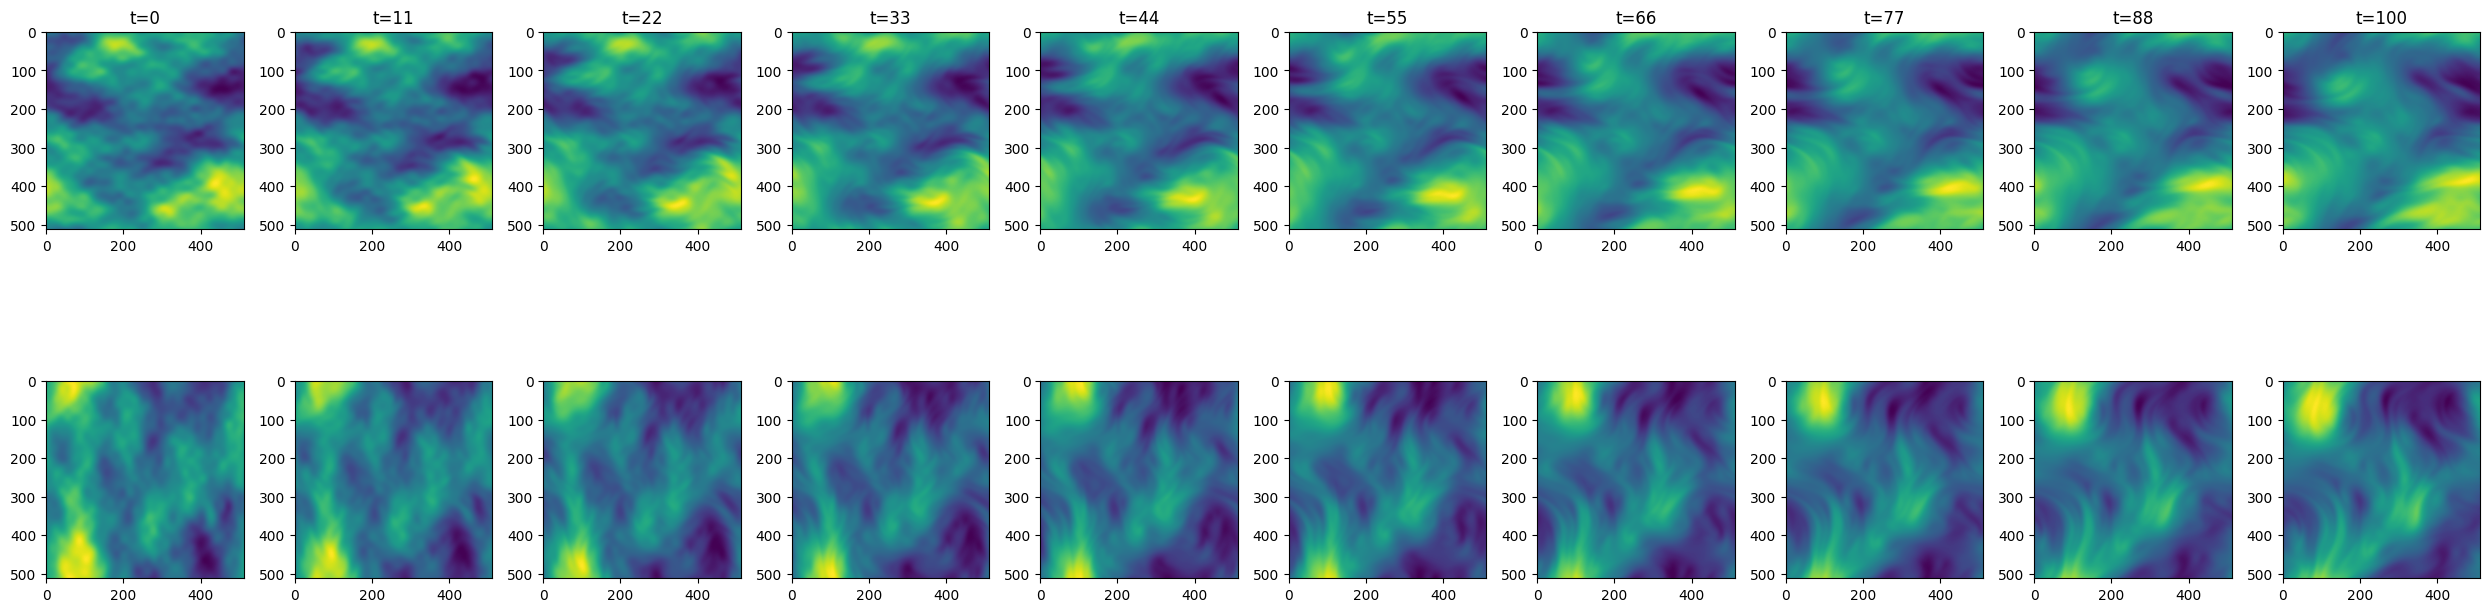

In [15]:
ts = np.linspace(0, 100, 10).astype(int)
fig, ax = plt.subplots(2, len(ts), figsize=(25, 8))
for i, t in enumerate(ts):
    ax[0,i].imshow(amira_data[t,:,:,0])
    #ax[i,0].set_title(f"t={t}")
    ax[1,i].imshow(amira_data[t,:,:,1])
    ax[0,i].set_title(f"t={t}")
plt.tight_layout()
plt.show()

In [2]:
fold = nn.Fold(output_size=(8, 8), kernel_size=(2, 2), stride=(2, 2))
unfold = nn.Unfold(kernel_size=(2, 2), stride=(2, 2))
x = torch.randn(1, 1, 8, 8)
x_unfold = unfold(x)
print(x_unfold.shape)
x_fold = fold(x_unfold)
print(x_fold.shape)

torch.Size([1, 4, 16])
torch.Size([1, 1, 8, 8])


In [11]:
import numpy as np

def read_binary_amira_mesh(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read()

    # Locate binary data section
    marker_idx = raw_data.find(b'@1')
    if marker_idx == -1:
        raise ValueError("Could not find binary data section in Amira file.")

    data_start = marker_idx + 3  # Skip '@1\n'
    
    # Use the correct dtype (update this based on your test)
    float_data = np.frombuffer(raw_data[data_start:], dtype=np.float64)  # or np.float32, np.int16
    
    # Reshape correctly
    data_shape = (512, 512, 1001, 2)  # Update based on actual channels
    float_data = float_data.reshape(data_shape)

    return float_data

# Run the function
amira_data = read_binary_amira_mesh("data/0000.am")
print("Data shape:", amira_data.shape)
print("Sample values:", amira_data[0, 0, 0])


ValueError: buffer size must be a multiple of element size

In [ ]:

def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class MLP(nn.Module): #might change name to FFN
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class ConvNeXtBlock(nn.Module):
    r"""Taken from: https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
    ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, emb_dim, layer_scale_init_value=1e-6, layer_norm_eps=1e-5):
        super().__init__()
        self.dwconv = nn.Conv2d(
            emb_dim, emb_dim, kernel_size=7, padding=3, groups=emb_dim
        )  # depthwise conv
        
        self.norm = nn.LayerNorm(emb_dim, eps=layer_norm_eps)
        self.pwconv1 = nn.Linear(
            emb_dim, 4 * emb_dim
        )  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * emb_dim, emb_dim)
        self.weight = (
            nn.Parameter(layer_scale_init_value * torch.ones((emb_dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )  # was gamma before
        

    def forward(self, x):
        batch_size, sequence_length, hidden_size = x.shape
        #! assumes square images
        input_dim = math.floor(sequence_length**0.5)

        input = x
        x = x.reshape(batch_size, input_dim, input_dim, hidden_size)
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.weight is not None:
            x = self.weight * x
        x = x.reshape(batch_size, sequence_length, hidden_size)

        x = input + x
        return x
    

class ResNetBlock(nn.Module):
    # taken from poseidon code
    def __init__(self, config, dim):
        super().__init__()
        kernel_size = 3
        pad = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=1, padding=pad)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=1, padding=pad)
        self.bn1 = nn.BatchNorm2d(dim)
        self.bn2 = nn.BatchNorm2d(dim)

    def forward(self, x):
        batch_size, sequence_length, hidden_size = x.shape
        input_dim = math.floor(sequence_length**0.5)

        input = x
        x = x.reshape(batch_size, input_dim, input_dim, hidden_size)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, sequence_length, hidden_size)
        x = x + input
        return x


class LinearEmbedding(nn.Module):

    def __init__(self, emb_dim = 96, data_dim = (1,5,4,128,128), patch_size = (8,8), hiddenout_dim = 256):
        super().__init__()
        
        self.B, self.T, self.C, self.H, self.W = data_dim
        self.emb_dim = emb_dim
        self.pH, self.pW = patch_size
        self.hiddenout_dim = hiddenout_dim
        self.patch_grid_res = (self.H // self.pH, self.W // self.pW)
        
        act = nn.GELU

        assert self.H % self.pH == 0 and self.W % self.pW == 0, "spatial input dim must be divisible by patch_size"
        assert self.H == self.W, "must be square"
        

        self.patchify = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.unpatchify = nn.Fold(output_size=(self.H, self.W), kernel_size=patch_size, stride=patch_size)

        #self.patch_position_embeddings = get_embeddings((1, 1, config.patch_num * config.patch_num, self.dim))
        #self.time_embed = get_embeddings((1, config.get("max_time_len", 20), 1, self.dim))

        self.pre_proj = nn.Sequential(
            nn.Linear(self.C * self.pH * self.pW, self.emb_dim),
            act(),
            nn.Linear(self.emb_dim, self.emb_dim),
        )

        self.post_proj = nn.Sequential(
            nn.Linear(self.emb_dim, self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.C * self.pH * self.pW),
        )

    #def get_pos_embeddings(self, t_len):
    #    return (self.time_embed[:, :t_len] + self.patch_position_embeddings).view(1, -1, self.emb_dim)  # (1, t*p*p, d)

    def encode(self, x, proj=True):

        B = x.size(0)
        #print(1, x.shape)
        x = rearrange(x, "b t c h w -> (b t) c h w") #might change to .permute
        #print(2, x.shape)
        x = self.patchify(x)  
        #print(3, x.shape)
        x = rearrange(x, "(b t) d pp -> b (t pp) d", b=B) # should think about this
        #print(4, x.shape)

        # TODO: add Positional Encoding
        if proj:
            #print(5, x.shape)
            return self.pre_proj(x)#.transpose(1, 2)
        else:
            return x#.transpose(1, 2)

    def decode(self, x, proj=True):
        if proj:
            x = self.post_proj(x)  

        B = x.size(0)
        x = rearrange(x, "b (t pp) d -> (b t) d pp", pp=self.patch_grid_res[0]*self.patch_grid_res[1]) #might change to .permute
        x = self.unpatchify(x)  
        #print(x.shape)
        x = rearrange(x, "(b t) c h w -> b t c h w", b=B)

        return x
    
 
class PatchMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(4*emb_dim, 2*emb_dim)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b (h s1 w s2) c -> b (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W) #might change to .permute
        x = self.linear(x)
        return x

class PatchUnMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(emb_dim, 2*emb_dim)
    
    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L))
        #print(x.shape, H, W)
        x = self.linear(x)
        #print(x.shape)
        x = rearrange(x, 'b (h w) (s1 s2 c) -> b (h s1 w s2) c', s1=2, s2=2, h=H, w=W) #might change to .permute
        return x


class WindowAttention(nn.Module):

    def __init__(self, emb_dim, window_size, num_heads, qkv_bias=True, use_flex_attn=True):

        super().__init__()
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.use_flex_attn = use_flex_attn # original from logits scale BCAT?

        assert emb_dim % num_heads == 0, "embedding dimension must be divisible by number of heads"

        
        if self.use_flex_attn: 
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  
        
        relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
        relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8 TODO: understand why
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1)  
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(emb_dim))
            self.v_bias = nn.Parameter(torch.zeros(emb_dim))
            # TODO: understand why not key bias
        else:
            self.q_bias = None
            self.v_bias = None
        self.proj_out = nn.Linear(emb_dim, emb_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):

        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        #print(x.shape, self.qkv.weight.shape, qkv_bias.shape)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        #print('test')
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        if self.use_flex_attn:
            flex_attn = torch.clamp(self.flex_attn, max=torch.log(torch.tensor(1. / 0.01))).exp()
            attn = attn * flex_attn

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1) 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj_out(x)
        return x
    
class SwinV2Block(nn.Module): #change name to something else

    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size=4, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, use_flex_attn=True, use_proj_in=True, 
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        #self.use_proj_in = use_proj_in
        
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(emb_dim)
        #print('test')
        self.attn = WindowAttention(
            emb_dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, use_flex_attn=use_flex_attn)
        #print('test')
        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA (from original swin paper source code)
            H, W = self.patch_grid_res
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            #print('test')
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.patch_grid_res
        B, L, C = x.shape
        #print(L, H, W)
        #print('t', x.shape)
        #if self.use_proj_in:
        #    x = x.transpose(1,2)
        #    x = self.proj_in(x)
        #    x = x.transpose(1,2)
        #else:
        assert L == H * W, "input feature has wrong size for window partitioning (use proj_in=True for projection)"
        #print('u', x.shape)
        shortcut = x
        x = x.view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        #TODO: save attention mask somewhere?
        
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.norm1(x)

        x = x + self.norm2(self.mlp(x))

        return x
    
class SwinStage(nn.Module): # change name since stage also includes patch merge formally
    
    def __init__(self, emb_dim, patch_grid_res, stage_depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, use_flex_attn=True,
                 norm_layer=nn.LayerNorm):

        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.stage_depth = stage_depth

        assert stage_depth % 2 == 0, "stage depth must be divisible by 2"

        # build blocks
        self.blocks = nn.ModuleList([
            SwinV2Block(emb_dim=emb_dim, patch_grid_res=patch_grid_res,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, 
                                 use_flex_attn=use_flex_attn,
                                 norm_layer=norm_layer
                                 )
            for i in range(stage_depth)])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x
    
class SwinUnet(nn.Module):
    def __init__(self, emb_dim, data_dim, patch_size, hiddenout_dim, depth, 
                 stage_depths, num_heads, window_size=8, mlp_ratio=4., 
                 qkv_bias=True, use_flex_attn=True, norm_layer=nn.LayerNorm,
                 act=nn.GELU, skip_connect=ConvNeXtBlock):
        super().__init__()

        self.embedding = LinearEmbedding(emb_dim, data_dim, patch_size, hiddenout_dim)

        self.blockDown = nn.ModuleList()
        self.blockUp = nn.ModuleList()
        self.patchMerges = nn.ModuleList()
        self.patchUnmerges = nn.ModuleList()
        self.skip_connects = nn.ModuleList()
        # TODO: implement act 

        self.depth = depth

        for i in range(depth):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            
            #print(emb_dim * 2**i, patch_grid_res, stage_depths[i], num_heads[i], window_size)
            self.blockDown.append(
                SwinStage(
                    emb_dim * 2**i, 
                    patch_grid_res=patch_grid_res,
                    stage_depth=stage_depths[i], 
                    num_heads=num_heads[i], 
                    window_size=window_size, 
                    mlp_ratio = mlp_ratio, 
                    qkv_bias = qkv_bias, 
                    use_flex_attn = use_flex_attn, 
                    norm_layer = norm_layer
                )
            )
            self.patchMerges.append(PatchMerge(emb_dim * 2**i))
            #self.skip_connects.append(skip_connect(emb_dim * 2**i, 
            #                                       layer_scale_init_value=1e-6, 
            #                                       layer_norm_eps=1e-5))


        #print(emb_dim * 2**depth, (data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth)))
        self.blockMiddle = SwinStage(
            emb_dim * 2**depth,
            patch_grid_res=(data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth)),
            stage_depth=stage_depths[depth],
            num_heads=num_heads[depth],
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            use_flex_attn=use_flex_attn,
            norm_layer=norm_layer
        )

        for i in reversed(range(depth)):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            #print(emb_dim * 2**i, patch_grid_res, stage_depths[2*depth - i], num_heads[2*depth - i], window_size)

            self.blockUp.append(
                SwinStage(
                    emb_dim * 2**i, 
                    patch_grid_res=patch_grid_res,
                    stage_depth=stage_depths[2*depth - i], 
                    num_heads=num_heads[2*depth - i], 
                    window_size=window_size, 
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    use_flex_attn=use_flex_attn,
                    norm_layer=norm_layer
                )
            )
            self.patchUnmerges.append(PatchUnMerge(emb_dim * 2**(i+1)))
            self.skip_connects.append(skip_connect(emb_dim * 2**i,
                                                   layer_scale_init_value=1e-6,
                                                   layer_norm_eps=1e-5))

    def forward(self, x):
        skips = []

        x = self.embedding.encode(x, proj=True)
        #print(x.shape)
        for i in range(self.depth):
            #print(i)
            x = self.blockDown[i](x)
            #print(x.shape)
            skips.append(x)
            x = self.patchMerges[i](x)
            #print(x.shape)
        #print('middle')
        x = self.blockMiddle(x)
        #print(x.shape)
        for i in range(self.depth):
            #print(i)
            x = self.patchUnmerges[i](x)
            #print(x.shape)
            x = x + self.skip_connects[i](skips[self.depth - i - 1])
            #print(x.shape)
            x = self.blockUp[i](x)
            #print(x.shape)

        x = self.embedding.decode(x, proj=True)

        return x


# 2 depth example
x = torch.randn(1, 1, 1, 256, 256).to(torch.device('cuda'))
model = SwinUnet(emb_dim=96,
                data_dim=x.shape,
                patch_size=(4,4),
                hiddenout_dim=256,
                depth=2,
                stage_depths=[2, 2, 6, 2, 2],
                num_heads=[3, 6, 12, 6, 3],
                window_size=4, 
                act=nn.GELU,
                skip_connect=ConvNeXtBlock,
                device=torch.device('cuda')).to(torch.device('cuda'))
y = model(x)
# count trainable params
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


# 3 depth example
x2 = torch.randn(1, 1, 1, 512, 512)
model2 = SwinUnet(emb_dim=96,
                  data_dim=x2.shape,
                  patch_size=(4,4),
                    hiddenout_dim=256,
                    depth=3,
                    stage_depths=[2, 2, 2, 6, 2, 2, 2],
                    num_heads=[3, 6, 12, 24, 12, 6, 3],
                    window_size=4,
                    act=nn.GELU,
                    skip_connect=ConvNeXtBlock)
y2 = model2(x2)
print(sum(p.numel() for p in model2.parameters() if p.requires_grad))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument max in method wrapper_CUDA_clamp_Tensor)

In [29]:

x = torch.randn(2, 1, 4, 32, 32)
patch_size = (4, 4)
layer1 = LinearEmbedding(data_dim=x.shape, emb_dim=96, patch_size=patch_size, hiddenout_dim=256)

layer2 = SwinStage(emb_dim=96, 
                   patch_grid_res=(x.shape[3] // patch_size[0], x.shape[4] // patch_size[0]), 
                   stage_depth=2,
                   num_heads=3, 
                   window_size=4
                   )
layer3 = PatchMerge(emb_dim=96)
layer4 = SwinStage(emb_dim=192, 
                   patch_grid_res=(x.shape[3] // patch_size[0] // 2, x.shape[4] // patch_size[0] // 2), 
                   stage_depth=4,
                   num_heads=6, 
                   window_size=4
                   )
layer5 = PatchUnMerge(emb_dim=192)
layer6 = SwinStage(emb_dim=96, 
                   patch_grid_res=(x.shape[3] // patch_size[0], x.shape[4] // patch_size[0]), 
                   stage_depth=2,
                   num_heads=3, 
                   window_size=4
                   )
convnext = ConvNeXtBlock(emb_dim=96)

print(x.shape)
x = layer1.encode(x)
print(x.shape)
x = layer2(x)
shortcut = x

x = layer3(x)

x = layer4(x)
print(x.shape)

#x = convnext(shortcut) + layer5(x)
x = layer5(x)
print(x.shape)
x = layer6(x)

x = layer1.decode(x)




torch.Size([2, 1, 4, 32, 32])
torch.Size([2, 64, 96])
torch.Size([2, 16, 192])
torch.Size([2, 16, 192]) 4 4
torch.Size([2, 16, 384])
torch.Size([2, 64, 96])


In [13]:

import torch
from torch.utils.data import ConcatDataset, Dataset
import torchvision
import h5py
import random

class HDF5ConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)

    def time_window(self):
        return self.datasets[0].time_window

    def absmax_vel(self):
        return max(d.absmax_vel() for d in self.datasets)

    def absmax_temp(self):
        return max(d.absmax_temp() for d in self.datasets)
    
    def absmax_phase(self):
        return max(d.absmax_phase() for d in self.datasets)
    
    def _get_temp_full(self, num):
        return self.datasets[num]._data['temp']

    def normalize_temp_(self, absmax_temp=None):
        if not absmax_temp:
            absmax_temp = self.absmax_temp()
        for d in self.datasets:
            d.normalize_temp_(absmax_temp)
        return absmax_temp

    def normalize_vel_(self, absmax_vel=None):
        if not absmax_vel:
            absmax_vel = self.absmax_vel()
        for d in self.datasets:
            d.normalize_vel_(absmax_vel)
        return absmax_vel
    
    def normalize_phase_(self, absmax_phase=None):
        if not absmax_phase:
            absmax_phase = self.absmax_phase()
        for d in self.datasets:
            d.normalize_phase_(absmax_phase)
        return absmax_phase

    def datum_dim(self):
        return self.datasets[0].datum_dim()
    
    def get_validation_stacks(self, dataset_num):
        
        if dataset_num >= len(self.datasets) or dataset_num < 0:
            raise IndexError(f"Dataset index {dataset_num} is out of range. Total datasets: {len(self.datasets)}")

        dataset = self.datasets[dataset_num]

        temp_data = dataset._data['temp'] 
        velx_data = dataset._data['velx']  
        vely_data = dataset._data['vely'] 
        phase_data = dataset._data['dfun']


        interleaved_vel = torch.empty(
        velx_data.size(0) * 2, velx_data.size(1), velx_data.size(2),
        dtype=velx_data.dtype, device=velx_data.device
        )  

        interleaved_vel[0::2] = velx_data  # Fill even indices with velx
        interleaved_vel[1::2] = vely_data  # Fill odd indices with vely

        temp_data = temp_data.unsqueeze(0)        
        interleaved_vel = interleaved_vel.unsqueeze(0)  
        phase_data = phase_data.unsqueeze(0)         
        #del velx_data, vely_data
        return temp_data, interleaved_vel, phase_data
    
    

class PFLoader(Dataset):
    def __init__(self,
                 filename,
                 discard_first,
                 use_coords,
                 time_window,
                 push_forward_steps=0,
                 transform=False):
        #super().__init__()
        self.time_window = time_window
        self.push_forward_steps = push_forward_steps
        self.filename = filename
        self.discard_first = discard_first
        self.temp_scale = None
        self.vel_scale = None
        self.phase_scale = None

        if use_coords:
            self.coords_dim = 2
        else:
            self.coords_dim = 0
        self.temp_channels = self.time_window
        self.vel_channels = self.time_window * 2
        self.phase_channels = self.time_window

        self.in_channels = self.coords_dim + self.temp_channels + self.vel_channels + self.phase_channels
        self.out_channels = 4 * self.time_window

        self.transform = transform
        self.read_files()
    
    def read_files(self):
        self._data = {}
        with h5py.File(self.filename, 'r') as f:
            self._data['temp'] = torch.nan_to_num(torch.from_numpy(f['temperature'][:][self.discard_first:])).float()
            self._data['velx'] = torch.nan_to_num(torch.from_numpy(f['velx'][:][self.discard_first:])).float()
            self._data['vely'] = torch.nan_to_num(torch.from_numpy(f['vely'][:][self.discard_first:])).float()
            self._data['dfun'] = torch.nan_to_num(torch.from_numpy(f['dfun'][:][self.discard_first:])).float()
            self._data['x'] = torch.from_numpy(f['x'][:][self.discard_first:]).float()
            self._data['y'] = torch.from_numpy(f['y'][:][self.discard_first:]).float()

        if self.temp_scale and self.vel_scale and self.phase_scale:
            self.normalize_temp_(self.temp_scale)
            self.normalize_vel_(self.vel_scale)
            self.normalize_phase_(self.phase_scale)

    def _transform(self, coords, temp, vel, phase, temp_label, vel_label, phase_label):
        if self.transform:
            if random.random() > 0.5:
                
                #coords = torchvision.transforms.functional.hflip(coords)
                temp = torchvision.transforms.functional.hflip(temp)
                vel = torchvision.transforms.functional.hflip(vel)
                phase = torchvision.transforms.functional.hflip(phase)
                temp_label = torchvision.transforms.functional.hflip(temp_label)
                vel_label = torchvision.transforms.functional.hflip(vel_label)
                phase_label = torchvision.transforms.functional.hflip(phase_label)
                
                # Flip x-velocity (even indices of the interleaved velocity tensor)
                #print(vel.shape)
                vel[0::2] *= -1  
                vel_label[0::2] *= -1 
        return (coords, temp, vel, phase, temp_label, vel_label, phase_label)

    def absmax_temp(self):
        return self._data['temp'].abs().max()

    def absmax_vel(self):
        return max(self._data['velx'].abs().max(), self._data['vely'].abs().max())
    
    def absmax_phase(self):
        return self._data['dfun'].abs().max()
    
    def normalize_temp_(self, scale):
        self._data['temp'] = 2 * (self._data['temp'] / scale) - 1
        self.temp_scale = scale

    def normalize_vel_(self, scale):
        for v in ('velx', 'vely'):
            self._data[v] = self._data[v] / scale
        self.vel_scale = scale

    def normalize_phase_(self, scale):
        self._data['dfun'] = self._data['dfun'] / scale
        self.phase_scale = scale

    def _get_temp(self, timestep):
        return self._data['temp'][timestep]
    
    def _get_phase(self, timestep):
        return torch.heaviside(self._data['dfun'][timestep], values=torch.Tensor([1]))  # pass phase as 0 to 1 values

    def _get_vel_stack(self, timestep):
        return torch.stack([
            self._data['velx'][timestep],
            self._data['vely'][timestep],
        ], dim=0)

    def _get_coords(self, timestep):
        x = self._data['x'][timestep]
        x /= x.max()
        y = self._data['y'][timestep]
        y /= y.max()
        #print('x:', x.shape, x[0], x[-1], x.min(), x.max(), x.mean())
        #print()
        #print('y:', y.shape, y[0], y[-1], y.min(), y.max(), y.mean())
        coords = torch.stack([x, y], dim=0)
        return coords

    def __len__(self):
        return self._data['temp'].size(0) - self.time_window - (self.time_window * self.push_forward_steps - 1) 

    def _get_timestep(self, timestep):
        
        coords = self._get_coords(timestep)
        temp = torch.stack([self._get_temp(timestep + k) for k in range(self.time_window)], dim=0)
        vel = torch.cat([self._get_vel_stack(timestep + k) for k in range(self.time_window)], dim=0) 
        phase = torch.stack([self._get_phase(timestep + k) for k in range(self.time_window)], dim=0)
        
        base_time = timestep + self.time_window 
        temp_label = torch.stack([self._get_temp(base_time + k) for k in range(self.time_window)], dim=0)
        vel_label = torch.cat([self._get_vel_stack(base_time + k) for k in range(self.time_window)], dim=0)
        phase_label = torch.stack([self._get_phase(base_time + k) for k in range(self.time_window)], dim=0)
        '''
        if self.time_window == 1:
            coords = coords.unsqueeze(0)  # Add the time dimension
            temp = temp.unsqueeze(0)
            vel = vel.unsqueeze(0)
            phase = phase.unsqueeze(0)
            temp_label = temp_label.unsqueeze(0)
            vel_label = vel_label.unsqueeze(0)
            phase_label = phase_label.unsqueeze(0)
        '''
        return self._transform(coords, temp, vel, phase, temp_label, vel_label, phase_label)

    def __getitem__(self, timestep):
        
        args = list(zip(*[self._get_timestep(timestep + k * self.time_window) for k in range(self.push_forward_steps)]))
        return tuple([torch.stack(arg, dim=0) for arg in args])

import yaml
path = 'conf/local_01DS8_1.yaml'
with open(path, 'r') as file:
    config = yaml.safe_load(file)
train_files = [config['data_path'] + file for file in config['training']['files']]
val_files = [config['data_path'] + file for file in config['validation']['files']]
#print(len(train_files), len(val_files)) 

train_dataset = HDF5ConcatDataset([PFLoader(file, 
                                            discard_first=200, 
                                            use_coords=False, 
                                            time_window = 1, 
                                            push_forward_steps=1,
                                            transform=False) for file in train_files])
train_max_temp = train_dataset.normalize_temp_()
train_max_vel = train_dataset.normalize_vel_()
train_max_phase = train_dataset.normalize_phase_()

in_channels = train_dataset.datasets[0].in_channels
out_channels = train_dataset.datasets[0].out_channels
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
                                batch_size=64,
                                shuffle=True)

for coords, temp, vel, phase, temp_label, vel_label, phase_label in train_loader:
    print(temp.shape)
    break

torch.Size([64, 1, 1, 48, 48])
